In [ ]:
# imports
from load_data import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re


In [ ]:
# Load Data
fp = "/Users/augusttollerup/Documents/SEM4/Fagprojekt/Data/agg-cleaned.csv"

df = load_dataset(fp, type="pandas", sep=",")
print(df.columns)

In [ ]:
df_prod = df[df["type"] == "production"]
df_prod.reset_index(drop=True, inplace=True)

df_cons = df[df["type"] == "consumption"]
df_cons.reset_index(drop=True, inplace=True)



In [ ]:
# Print unique timeslots
print("Timeslots in entire dataset: ",len(df["timeslot"]))
print("Timeslots in production: ",len(df_prod["timeslot"]))
print("Timeslots in consumption: ",len(df_cons["timeslot"]))

In [ ]:
# Get index for timeslot = 01-01-2018 00:01:00

def create_ideal_index(index_start, index_end):
    new_index = pd.date_range(start = index_start, end = index_end, freq = "1H")
    # Convert new_index to string
    new_index = [str(x) for x in new_index]
    return new_index


In [ ]:
def plot_missing_dates_on_timeline(start, end, missing, title = "Missing timeslots"):
    """Plot missing dates on timeline

    Args:
        min (datetime): start date on timeline
        max (datetime): end date on timeline
        missing (list): list of missing dates in the interval
        title (str, optional): Plot title. Defaults to "Missing timeslots".
    """
    
    # Plot missing timeslot values 
    # Inspired by https://matplotlib.org/3.5.1/gallery/lines_bars_and_markers/timeline.html

    # Choose some nice levels
    levels = np.tile([-5, 5, -3, 3, -1, 1],
                    int(np.ceil(len(missing)/6)))[:len(missing)]

    # Create figure and plot a stem plot with the date
    fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)
    ax.set(title=title)

    ax.vlines(missing, 0, levels, color="tab:red")  # The vertical stems.
    ax.plot(missing, np.zeros_like(missing), "-o",
            color="k", markerfacecolor="w")  # Baseline and markers on it.

    # remove y axis and spines
    ax.yaxis.set_visible(False)
    ax.spines[["left", "top", "right"]].set_visible(False)

    # Set x-axis interval
    ax.set_xlim(start, end)

    ax.margins(y=0.1)
    plt.show()

In [ ]:
def plot_missing_timeslots(start, end, ideal, missing, title = "Missing timeslots"):
    first_timeslot = start
    last_timeslot = end

    # Set first and last element of ideal to x_labels
    x_labels = missing.copy()
    x_labels[0] = first_timeslot
    x_labels[-1] = last_timeslot

    # plot dot on horisontal line for ideal timeslots
    plt.rcParams["figure.figsize"] = (22,3)
    plt.plot(ideal, [0] * len(ideal), "-o", markerfacecolor="none", markeredgecolor="black", markersize=1)
    # Show only first and last x-axis label
    # Plot vertical line for missing timeslots with red dot
    plt.vlines(missing, 0, 1, color="red", linewidth=1, label="Missing", alpha=0.5, linestyle="--")
    # Rotate x-axis labels
    plt.xticks([first_timeslot] + missing + [last_timeslot], rotation=90)
    plt.legend()
    plt.title(title)
    plt.show()



In [ ]:
# Get unique meter_ids
meter_ids_unique = df_prod.meter_id.unique()
print(len(meter_ids_unique))

In [ ]:
# Fix timeslot
def fix_timeslot(timeslot):
    # Pandas convert +01:00 to +02:00
    timeslot = pd.to_datetime(timeslot)
    timeslot = timeslot.tz_convert(tz = "UTC")
    # Convert to string
    timeslot = str(timeslot)
    
    return timeslot


In [ ]:
# Loop through meter_ids and calculate yearly coverage
full_coverage_meter_ids = []

# Define dataset to use
df_loop = df_cons

df_coverages = pd.DataFrame(columns=["meter_id", "year_coverage", "first_timeslot", "last_timeslot"])

for idx, meter_id in enumerate(meter_ids_unique):
    timeslots_for_meter = sorted(df_loop[df_loop["meter_id"] == meter_id]["timeslot"].values)

    # Convert timeslot to UTC
    timeslots_for_meter = [pd.to_datetime(x).tz_convert("UTC").strftime("%Y-%m-%d %H:%M:%S+00:00") for x in timeslots_for_meter]

    # Get first and last timeslot
    first_timeslot = fix_timeslot(str(timeslots_for_meter[0]))
    last_timeslot = fix_timeslot(str(timeslots_for_meter[-1]))

    # print("First timeslot: ", first_timeslot)
    # print("Last timeslot: ", last_timeslot)

    new_index = create_ideal_index(first_timeslot, last_timeslot)

    # print("New index first timeslot: ", new_index[0])
    # print("New index last timeslot: ", new_index[-1])

    overlap = list(set(timeslots_for_meter) & set(new_index))
    missing = list(set(new_index) - set(timeslots_for_meter))
    
    # Calculate overlap percentage
 
    coverage = len(overlap) / len(new_index) * 100
    print("Meter_id: ", meter_id, " Coverage: ", coverage, ", ", idx, " out of ", len(meter_ids_unique))
    df_coverages.loc[idx] = [meter_id, coverage, first_timeslot, last_timeslot]


In [ ]:
df_coverages = df_coverages.sort_values(by="year_coverage", ascending=False)
print(df_coverages.head())

In [ ]:
# Save to csv
df_coverages.to_csv("year_coverage_consumption.csv", index=False)

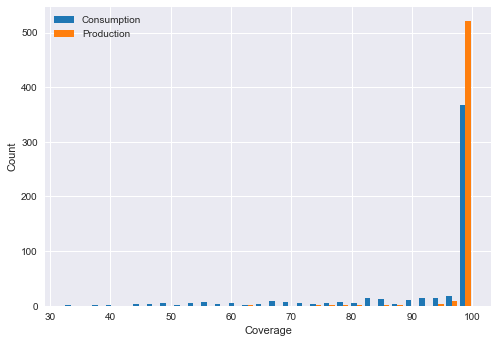

In [18]:
# Load csv
df_coverages_cons = pd.read_csv("year_coverage_consumption.csv")
df_coverages_prod = pd.read_csv("year_coverage_production.csv")
# Round to 1 decimal
df_coverages_cons["year_coverage"] = df_coverages_cons["year_coverage"].round(2)
df_coverages_prod["year_coverage"] = df_coverages_prod["year_coverage"].round(2)

# Plot  
# Set plot background color
plt.style.use('seaborn')
plt.hist([df_coverages_cons["year_coverage"],df_coverages_prod["year_coverage"]], bins=30, label=["Consumption", "Production"],
                    color=["tab:blue", "tab:orange"])
plt.ylabel("Count")
plt.xlabel("Coverage")
plt.legend(["Consumption", "Production"])
plt.show()


In [19]:
# Find meters with 100% coverage
df_coverages_cons_100 = df_coverages_cons[df_coverages_cons["year_coverage"] == 100]
df_coverages_prod_100 = df_coverages_prod[df_coverages_prod["year_coverage"] == 100]

print(r"Consumption Meters with 100% coverage: ", len(df_coverages_cons_100), " out of ", len(df_coverages_cons))
print(r"Production Meters with 100% coverage: ", len(df_coverages_prod_100), " out of ", len(df_coverages_prod))

Consumption Meters with 100% coverage:  358  out of  542
Production Meters with 100% coverage:  478  out of  542


In [20]:
# For each meter caluclate the time between first and last timeslot
df_coverages_cons_100["time_between_first_last"] = pd.to_datetime(df_coverages_cons_100["last_timeslot"]) - pd.to_datetime(df_coverages_cons_100["first_timeslot"])
df_coverages_prod_100["time_between_first_last"] = pd.to_datetime(df_coverages_prod_100["last_timeslot"]) - pd.to_datetime(df_coverages_prod_100["first_timeslot"])

# Convert time_between_first_last to years
df_coverages_cons_100["time_between_first_last"] = df_coverages_cons_100["time_between_first_last"] / pd.Timedelta(days=365)
df_coverages_prod_100["time_between_first_last"] = df_coverages_prod_100["time_between_first_last"] / pd.Timedelta(days=365)

# Return only meters with more than 1 year of coverage
df_coverages_cons_100 = df_coverages_cons_100.loc[df_coverages_cons_100["time_between_first_last"] > 1]
df_coverages_prod_100 = df_coverages_prod_100.loc[df_coverages_prod_100["time_between_first_last"] > 1]

print(r"Consumption Meters with more than 1 year of 100% coverage: ", len(df_coverages_cons_100), " out of ", len(df_coverages_cons))
print(r"Production Meters with more than 1 year of 100% coverage: ", len(df_coverages_prod_100), " out of ", len(df_coverages_prod))

# Save to csv
df_coverages_cons_100.to_csv("year_coverage_consumption_100.csv", index=False)
df_coverages_prod_100.to_csv("year_coverage_production_100.csv", index=False)

Consumption Meters with more than 1 year of 100% coverage:  137  out of  542
Production Meters with more than 1 year of 100% coverage:  163  out of  542


/var/folders/b1/gpnk8rp50gd31snzzh0dyycr0000gn/T/ipykernel_35268/1765777603.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coverages_cons_100["time_between_first_last"] = pd.to_datetime(df_coverages_cons_100["last_timeslot"]) - pd.to_datetime(df_coverages_cons_100["first_timeslot"])
/var/folders/b1/gpnk8rp50gd31snzzh0dyycr0000gn/T/ipykernel_35268/1765777603.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coverages_prod_100["time_between_first_last"] = pd.to_datetime(df_coverages_prod_100["las

In [30]:
# Create dataset for production with meters with 100% coverage
cons_new_df = pd.DataFrame(columns=["meter_id", "timeslot", "num_kwh"])

for meter_id in df_coverages_cons_100["meter_id"]:
    # Find all timeslots for meter in df
    print("Meter_id: ", meter_id)
    timeslots_for_meter = df[df["meter_id"] == meter_id][["meter_id", "timeslot", "num_kwh"]]
    # Skip if num_kwh > 40 is found
    if not timeslots_for_meter.loc[timeslots_for_meter["num_kwh"] > 40].empty:
        continue

    # Convert timeslot to UTC
    timeslots_for_meter["timeslot"] = [pd.to_datetime(x).tz_convert("UTC").strftime("%Y-%m-%d %H:%M:%S+00:00") for x in timeslots_for_meter["timeslot"]]
    # Add to prod_new_df
    cons_new_df = pd.concat([cons_new_df,timeslots_for_meter], ignore_index = True)


# Save prod_new_df to csv
cons_new_df.to_csv("production_100_data.csv", index=False)


Meter_id:  0148117f-53bb-48ca-ae71-1523f099fb81
Meter_id:  bf1f9a38-e811-4378-8810-1cb774773e2d
Meter_id:  ffde7516-88ea-4e11-a4e5-d87fd8618288
Meter_id:  d5230fc7-e311-4880-98ac-9148b3f8291f
Meter_id:  cf87108a-987e-4f81-87bf-0b0f64a511bd
Meter_id:  c1919556-abe3-4be1-a448-e7eca099a0cc
Meter_id:  a0e14f40-a19b-4482-93c2-e000d1a84305
Meter_id:  63ae4c40-f358-4a1e-aa17-f3c51bf76cdc
Meter_id:  4b61aa71-7112-4f02-ab23-77d9c9305d20
Meter_id:  311d4515-202c-43f1-815f-45b5855e1d68
Meter_id:  c7b06116-17aa-470f-9456-682177ca850e
Meter_id:  068e0174-077e-413f-91f0-620b7d3ee0c8
Meter_id:  f4a8ee56-e68f-4b56-ac2d-48ca0f040203
Meter_id:  c608a72c-956e-46cf-9ab3-10de64c002b7
Meter_id:  96c6ea04-56ee-40af-b401-c646c8caa049
Meter_id:  2fe83bc4-2f99-4843-b626-d6a46bf02c28
Meter_id:  2835eec0-814a-4221-bbe7-f81f76f8703b
Meter_id:  c319c7a2-65cc-44e6-bbaf-9d0dd39f0890
Meter_id:  cfbbddbf-d18c-46a3-9f43-795c76fbaff3
Meter_id:  9a3eb28c-66a9-471d-83ce-397f4ae6872a
Meter_id:  92bf5dd3-8b13-4b7c-b7fe-5b394

In [28]:
# Save prod_new_df to csv
cons_new_df.to_csv("production_100_data.csv", index=False)